# Анализ данных осень 2021
# Анализ нетабличных данных

## Представление табличных данных

In [241]:
# Вспомним пример с прошлой лекции
import pandas as pd

# Загрузим данные о рекламе
posts = pd.read_csv('../08-ML_competition/data/raw/validate.tsv', sep='\t')
answers = pd.read_csv('../08-ML_competition/data/raw/validate_answers.tsv', sep='\t')

# соединим данные об объявлениях и величине охвата 
posts = posts.assign(id=posts.index)
answers = answers.assign(id=answers.index)
ads = pd.merge(posts, answers, on='id')

# Оставим только эти колонки
cols = ['cpm', 'hour_start', 'hour_end', 'publishers', 'audience_size', 'at_least_one']
ads = ads[cols]
ads.head(3)

,cpm,hour_start,hour_end,publishers,audience_size,at_least_one
0,220.0,1058,1153,"7,17",1906,0.0430
1,312.0,1295,1301,"3,18",1380,0.0130
2,70.0,1229,1249,"1,2,3,9,15,21",888,0.0878


In [242]:
# Добавим признаки
import numpy as np

# Простые признаки
ads = ads.assign(
                 duration=ads.hour_end - ads.hour_start,
                 n_publishers=ads.publishers.apply(lambda s: len(s.split(',')))
                )
# Преобразования и сложные признаки
ads = ads.assign(
                 log_duration=np.log2(ads.duration),
                 log_duration_x_audience=np.log2(ads.duration * ads.audience_size)
                 )

# Уберём колонки
ads = ads.drop(['hour_start', 'hour_end', 'publishers'], axis=1)

ads.head(3)

,cpm,audience_size,at_least_one,duration,n_publishers,log_duration,log_duration_x_audience
0,220.0,1906,0.0430,95,2,6.569856,17.466188
1,312.0,1380,0.0130,6,2,2.584963,13.015415
2,70.0,888,0.0878,20,6,4.321928,14.116344


<Figure size 1296x1224 with 0 Axes>

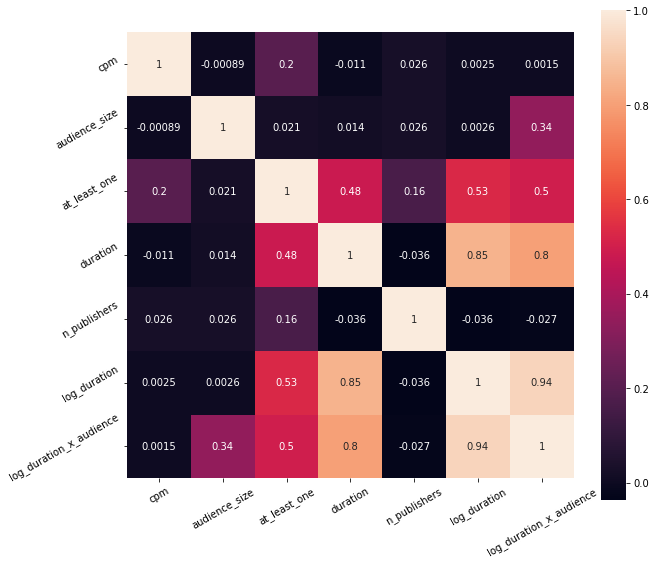

In [243]:
# Построим таблицу корреляции 
import matplotlib.pyplot as plt
import seaborn as sns

def heatmap(data: pd.DataFrame):
    plt.figure(figsize=(10, 9))
    sns.heatmap(data.corr(), square=True, linecolor='white', annot=True)
    plt.yticks(rotation=30)
    plt.xticks(rotation=30)
    plt.show()
    
plt.figure(figsize=(18, 17))
heatmap(ads)

In [244]:
list(ads.columns)

['cpm',
 'audience_size',
 'at_least_one',
 'duration',
 'n_publishers',
 'log_duration',
 'log_duration_x_audience']

In [245]:
# Спроецируем в 2d пространство
import umap

cols = [
     # 'cpm',
     # 'audience_size',
     # 'at_least_one',
     'duration',
     'n_publishers',
     'log_duration',
     'log_duration_x_audience'
]
points = umap.UMAP().fit_transform(ads[cols])

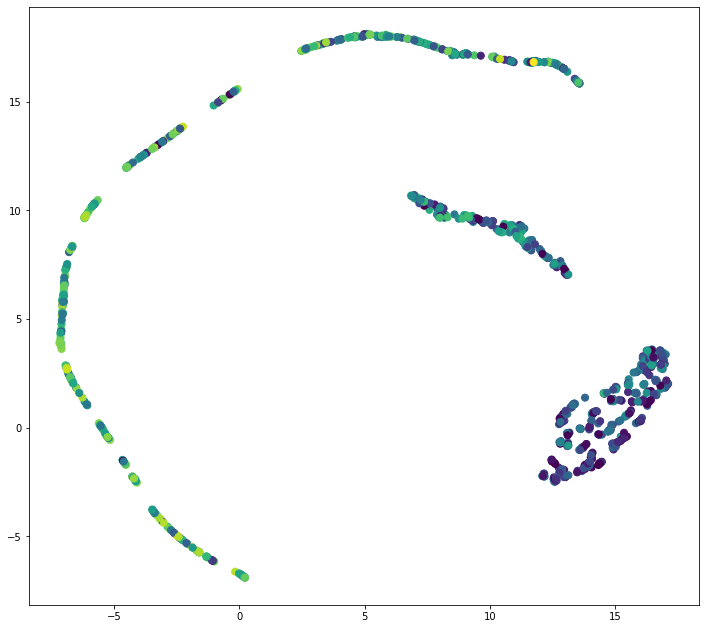

In [246]:
# нарисуем и цветом выделим величину целевой переменной

# Приведём к норм распределению, чтобы был виден переход цветов
color = np.log1p(ads.at_least_one * 100)

plt.figure(figsize=(12, 11))
plt.scatter(x=points[:, 0], y=points[:, 1], c=color, s=50)

## Проблема нетабличных данных

Например работа с текстовыми данными

### Загрузим текстовый датасет

In [247]:
# Возьмём пример текстового датасета

comms_params = pd.read_csv('data/raw/vdud.csv')
print(comms_params.shape)
comms_params.head()

(118, 11)


,full_title,guest,length,views,likes,dislikes,date,comments_num,likes/dislikes,views/likes,views/comments_num
0,Максим Фадеев - о конфликте с Эрнстом и русско...,Максим Фадеев,52,8621967,167000.0,11000.0,2017-05-16,30245,15.181818,51.628545,285.070822
1,Невзоров - о Фараоне и ориентации Милонова,Невзоров,85,14349677,326000.0,26000.0,2018-01-30,47203,12.538462,44.017414,303.999259
2,Колокольников,Колокольников,72,3884574,79000.0,9200.0,2018-05-22,11053,8.586957,49.171823,351.449742
3,"Собчак - о Навальном, крестном и выборах",Собчак,96,14875828,251000.0,67000.0,2017-10-24,52065,3.746269,59.266247,285.716470
4,"Щербаков - спецназ, панк-рок, любовь",Щербаков,99,21323332,789000.0,45000.0,2020-01-28,125871,17.533333,27.025769,169.406233


In [248]:
# Возьмём один выпуск

EPISODE_NAME = 'Камчатка – полуостров, про который забыли'
comms_params[comms_params.full_title == EPISODE_NAME]

,full_title,guest,length,views,likes,dislikes,date,comments_num,likes/dislikes,views/likes,views/comments_num
62,"Камчатка – полуостров, про который забыли",Камчатка,116,11425208,498000.0,14000.0,2020-06-02,55245,35.571429,22.942185,206.809811


In [249]:
import pickle

comms = pickle.load(open('data/raw/all_comms.pickle', 'rb'))
comms = comms[62]

print(len(comms))
comms[1:10]

17899


['Зачем тратить деньги на тролей если есть пенсионеры? Обучите пенсионеров интернету и у власти будет бесплатные интернет ваойска!',
 'Этот дом и дальше должен оставаться в таком состоянии. Потому что люди дураки и сами выбираю такое будущее на выборах!',
 'Искринее большое спасибо за вопрос за Крым. Вот дед идиот, нет чтобы заняться Камчаткой, он  Крымом радуется))',
 'единственное заслуга ВВП и то не на 100% это присоеденения нашего Крыма!!! обратно кнам',
 'бля за 350 штук я слетаю на багамские острова а отуда на канарские через ницу и еще останется🤦\u200d♂️🤦\u200d♂️🤦\u200d♂️',
 'подностю самодостаточный краи никаких субсидии дотации нетребуется толькоб немешали тут все есть. и золото и рыба и газ и туризм !!! а гдеже деньги тогда??? на афшорах!!!',
 'короче какоибы профан непосиотрел этот фильм , и как бы он нерассуждал , в голову смотря на все богатство и чудеса природы приходит одна вещь. Исландия тихо курит в сторонке должно быть так!!! в 1000 раз круче!!! а посему  нетак  потом

In [260]:
# Оставим только слова 

rus_alph = set(list('йцукенгшщзхъфывапролджэёячсмитьбю'))
drop_not_letters = lambda s: ''.join(list(filter(lambda c: c in rus_alph or c == ' ', s)))

comms = [drop_not_letters(comm.lower()) for comm in comms]

# уберем пустые комменты
comms = list(filter(lambda comm: len(comm) > 0, comms))
print(len(comms))

comms[1:10]

17465


['зачем тратить деньги на тролей если есть пенсионеры обучите пенсионеров интернету и у власти будет бесплатные интернет ваойска',
 'этот дом и дальше должен оставаться в таком состоянии потому что люди дураки и сами выбираю такое будущее на выборах',
 'искринее большое спасибо за вопрос за крым вот дед идиот нет чтобы заняться камчаткой он крымом радуется',
 'единственное заслуга ввп и то не на это присоеденения нашего крыма обратно кнам',
 'бля за штук я слетаю на багамские острова а отуда на канарские через ницу и еще останется',
 'подностю самодостаточный краи никаких субсидии дотации нетребуется толькоб немешали тут все есть и золото и рыба и газ и туризм а гдеже деньги тогда на афшорах',
 'короче какоибы профан непосиотрел этот фильм и как бы он нерассуждал в голову смотря на все богатство и чудеса природы приходит одна вещь исландия тихо курит в сторонке должно быть так в раз круче а посему нетак потомучто элитам и властям это ненужно а быдло терпит',
 'дудь заговорил о нефти по

In [261]:
# Посмотрим сколько уникальных слов

def merge_comms(comms: list[str]) -> str:
    return ' '.join(comms)
    
    
unique_words = merge_comms(comms).split(' ')
len(unique_words)

311764

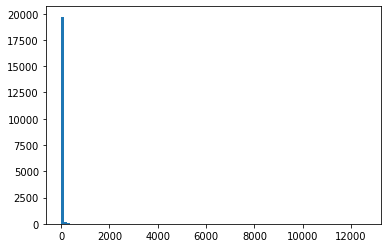

In [262]:
# Оставим частые слова

from collections import Counter

counts = Counter(merge_comms(comms).split())
freqs = list(counts.values())

plt.hist(freqs, bins=100)
plt.show()

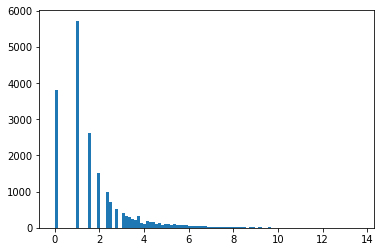

In [263]:
plt.hist(np.log2(freqs), bins=100)
plt.show()

In [264]:
# Оставим 20к самых частых слов

words = counts.most_common(20000)
words = [word for word, freq in words]
words[:30]

['и',
 'в',
 'не',
 'на',
 'что',
 'за',
 'с',
 'как',
 'а',
 'это',
 'спасибо',
 'я',
 'все',
 'у',
 'но',
 'юра',
 'так',
 'очень',
 'по',
 'бы',
 'то',
 'про',
 'же',
 'фильм',
 'там',
 'из',
 'от',
 'к',
 'люди',
 'просто']

In [265]:
# Профильтруем комментарии

words = set(words)
def drop_rare_words(comm: str) -> str:
    return ' '.join([w for w in comm.split() if w in words])

comms = list(map(drop_rare_words, comms))
comms[1:10]

['зачем тратить деньги на тролей если есть пенсионеры обучите пенсионеров интернету и у власти будет бесплатные интернет ваойска',
 'этот дом и дальше должен оставаться в таком состоянии потому что люди дураки и сами выбираю такое будущее на выборах',
 'искринее большое спасибо за вопрос за крым вот дед идиот нет чтобы заняться камчаткой он крымом радуется',
 'единственное заслуга ввп и то не на это присоеденения нашего крыма обратно кнам',
 'бля за штук я слетаю на багамские острова а отуда на канарские через ницу и еще останется',
 'подностю самодостаточный краи никаких субсидии дотации нетребуется толькоб немешали тут все есть и золото и рыба и газ и туризм а гдеже деньги тогда на афшорах',
 'короче какоибы профан непосиотрел этот фильм и как бы он нерассуждал в голову смотря на все богатство и чудеса природы приходит одна вещь исландия тихо курит в сторонке должно быть так в раз круче а посему нетак потомучто элитам и властям это ненужно а быдло терпит',
 'дудь заговорил о нефти по

### Попробуем представить текст как набор категориальных признаков

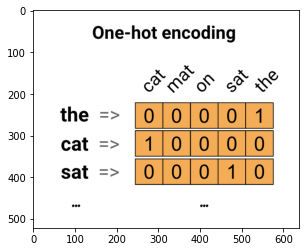

In [266]:
#Закодируем каждое слово с помощью one-hot encoding

plt.imshow(plt.imread('pics/onehot.png'))

In [267]:
# Используем энкодер из sklearn

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore').fit([[w] for w in words])

In [268]:
# Теперь слово представлено one-hot вектором

encoder.transform([['видео']])

<1x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [269]:
# Закодируем комментарии
from tqdm import tqdm

def encode_comment(comm: str) -> np.ndarray:
    words = [[w] for w in comm.split()]
    vecs = encoder.transform(words)
    return vecs.sum(axis=0)

print('comment shape', encode_comment(comms[0]).shape)

encoded_comms = []
for comm in tqdm(comms[:2000], total=len(comms)):
    encoded_comms.append(encode_comment(comm)) 

encoded_comms = np.stack(encoded_comms)
encoded_comms.shape

comment shape (1, 20000)


 11%|████████████▏                                                                                             | 2000/17465 [01:05<08:25, 30.59it/s]


(2000, 20000)

In [270]:
# Спроецируем в 2d пространство

points = umap.UMAP(random_state=42).fit_transform(encoded_comms)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


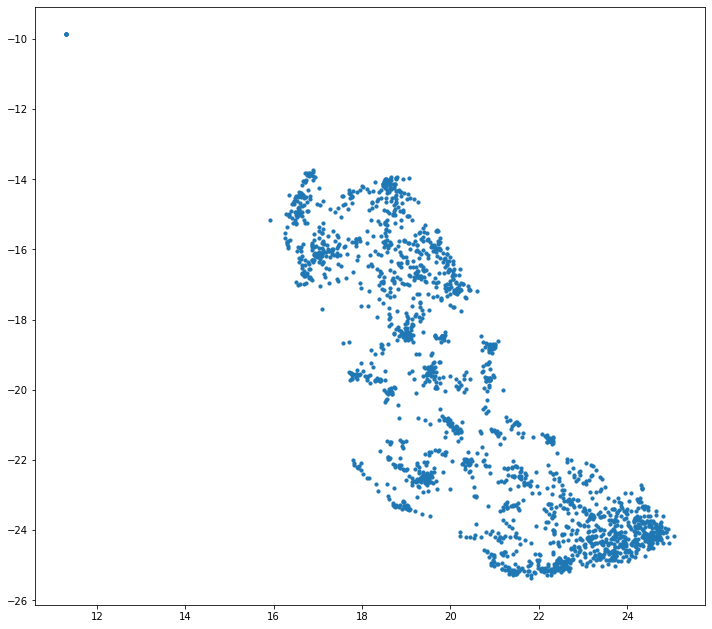

In [273]:
# Получилось плохо

plt.figure(figsize=(12, 11))
plt.scatter(x=points[:, 0], y=points[:, 1], s=10)

Недостатки:

    - тратится много памяти на слова
    - нельзя добавить дополнительное слово без перестройки модели
    - сильно обрезаем текст
    - результат так себе

### Попробуем вручную параметризовать слова

Пусть каждое слово будет представлено 5 признаками:

    1. Род (-1/0/1)
    1. Эмоциональная окраска         ([-1, 1])
    1. Принадлежность к теме "Дом"   ([-1, 1])
    1. Принадлежность к теме "Улица" ([-1, 1])
    1. Принадлежность к теме "Люди"  ([-1, 1])

In [274]:
comms[1:3]

['зачем тратить деньги на тролей если есть пенсионеры обучите пенсионеров интернету и у власти будет бесплатные интернет ваойска',
 'этот дом и дальше должен оставаться в таком состоянии потому что люди дураки и сами выбираю такое будущее на выборах']

In [275]:
# Сложно разметить больше 2 слов

vectors = {'зачем':   [0, 0.1, 0, 0, 0.2], 
           'тратить': [0, -0.3, ...]
           'деньги':  [],
           'на':      [], 
           'тролей':  [], 
           'если':    [], 
           'есть':    [], 
           'пенсионеры': []}



SyntaxError: invalid syntax (1098244707.py, line 5)

Проблемы:
    
    - Невозможно разметить все слова
    - Субъективность разметчиков
    - Ограниченное количество категорий

### Попробуем понять слово по контексту

зачем тратить деньги ____ тролей если есть пенсионеры

Варианты:

    - на
    - грязных
    - от
    - зелёных

По контексту можно понять какое слово может быть использовано в пропуске

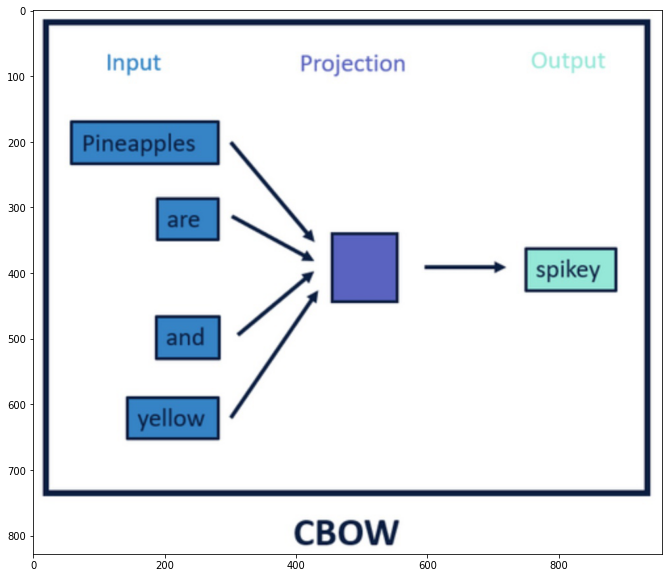

In [178]:
# Можно обучить классификатор на каждое слово

# Continuous Bag Of Words
plt.figure(figsize=(12, 10))
plt.imshow(plt.imread('pics/cbow.jpeg'))

## Отступление про градиентный спуск

Подробно градиентный спуск будет рассматриваться в следующем семестре на курсе машинного обучения. Пока что будет достаточно общего представления о назначении этого алгоритма. Рассмотрим применение алгоритма для решения простой задачи линейной регрессии в [посте на neurohive](https://neurohive.io/ru/osnovy-data-science/gradient-descent/)

## Вернёмся к cbow

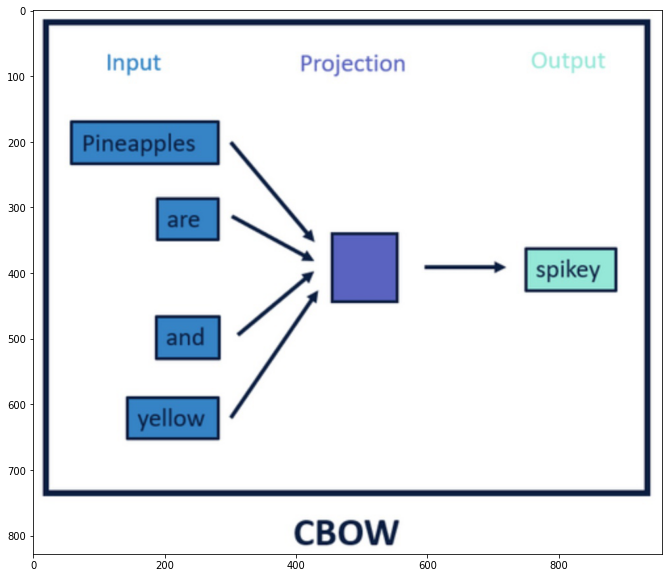

In [179]:
# Continuous Bag Of Words
plt.figure(figsize=(12, 10))
plt.imshow(plt.imread('pics/cbow.jpeg'))

In [290]:
# Для простоты реализации воспользуемся библиотекой gensim

from gensim.models import Word2Vec

sentences = [comm.split() for comm in comms]
model = Word2Vec(sentences=sentences,
                 sg=False,  # cbow model
                 vector_size=100,
                 window=5,
                 seed=42,
                 epochs=15, 
                 min_count=1
                 )
print('размерность векторов слов в модели:', model.wv.vectors.shape)

размерность векторов слов в модели: (20000, 100)


In [291]:
# Спроецируем в 2d пространство

points = umap.UMAP(random_state=42).fit_transform(model.wv.vectors[:500])

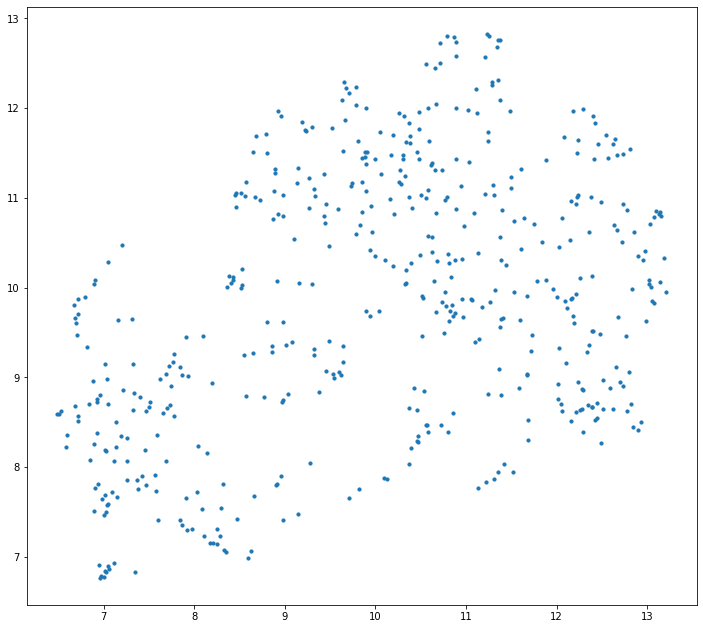

In [292]:
# Получилось неплохо?

plt.figure(figsize=(12, 11))
plt.scatter(x=points[:, 0], y=points[:, 1], s=10)

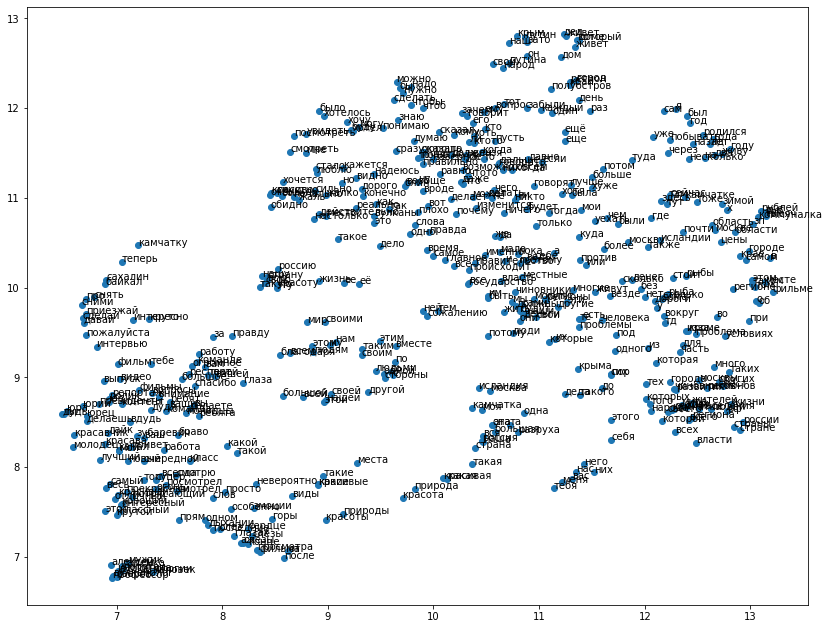

In [293]:
# Получилось неплохо
# Рассмотрим отдельные слова 

# plt.figure()
fig, ax = plt.subplots(figsize=(14, 11))
ax.scatter(points[:, 0], points[:, 1])

for i, txt in enumerate(model.wv.index_to_key[:500]):
    ax.annotate(txt, (points[i, 0], points[i, 1]))
    
# plt.xlim(6.5, 7.5)
# plt.ylim(2, 4)

In [294]:
model.wv.most_similar('путин')

[('присоединил', 0.8638548851013184),
 ('армию', 0.8548567891120911),
 ('зато', 0.8379021286964417),
 ('виноват', 0.8245684504508972),
 ('царь', 0.816242516040802),
 ('радуется', 0.7921347618103027),
 ('собрал', 0.7837111949920654),
 ('бояре', 0.7831323146820068),
 ('крым', 0.7826733589172363),
 ('восстановил', 0.7697104811668396)]

In [295]:
model.wv.vectors[:5]

array([[-1.0369059e+00,  1.3296339e-02,  2.4935916e-01, -6.1018765e-01,
        -5.1602930e-01,  9.3740147e-01, -6.6274107e-01,  2.5528526e-01,
        -1.0363529e+00,  4.3309882e-01,  6.4532155e-01,  4.3113205e-01,
        -5.1456776e-02,  6.5069735e-02,  7.4409626e-02,  2.9185855e-01,
         6.8816268e-01,  9.9313252e-02,  1.6048219e-02,  5.6369662e-01,
         3.3151159e-01, -3.0412090e-01, -6.2644118e-01,  7.0513904e-01,
        -1.1941328e+00,  1.1514676e+00, -5.0088847e-01,  3.1896067e-01,
         3.8799557e-01,  3.9005410e-02, -5.1062625e-02, -5.9053856e-01,
        -5.5939025e-01,  1.0929008e+00, -3.7327608e-01, -3.8346693e-01,
         1.3644238e-01,  7.9436153e-02, -1.7980032e-01,  8.7961918e-01,
        -4.7439280e-01, -1.3807651e-01,  8.4342581e-01, -1.4413425e-01,
        -1.1215715e+00,  1.4884328e+00,  2.1062019e-01, -9.6725091e-02,
         1.5514335e-01, -8.1758171e-01, -3.9660162e-01, -4.2480534e-01,
         2.6320949e-01,  1.7391932e-01,  3.4200764e-01, -1.06970

Проблемы:
    
    - Запутанность представлений
    - Качество зависит от корпуса текстов (но можно предобучить)

In [296]:
## Спроецируем комментарии в 2d пространство

def encode_comment(comm: str) -> np.ndarray:
    vecs = [model.wv.get_vector(w) for w in comm.split()]
    vecs = np.stack(vecs)
    return vecs.sum(axis=0)
    
print('encoded comment shape', encode_comment(comms[0]).shape)

encoded_comms = list(map(encode_comment, comms[:1000]))

encoded comment shape (100,)


In [297]:
# Спроецируем в 2d пространство

points = umap.UMAP(random_state=42).fit_transform(encoded_comms)

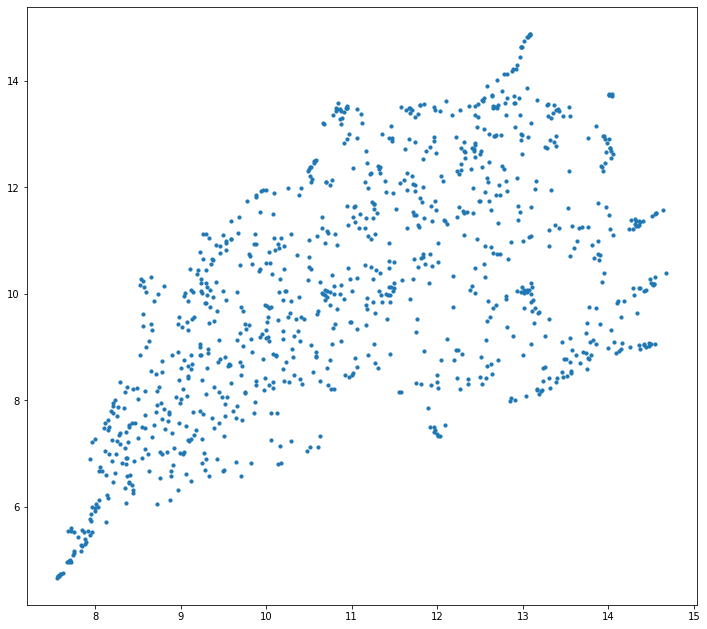

In [298]:
# Получилось неплохо?

plt.figure(figsize=(12, 11))
plt.scatter(x=points[:, 0], y=points[:, 1], s=10)

In [317]:
# from sklearn.metrics.pairwise import cosine_similarity

# max_sim_comment = ''
# max_sim_value = -float('inf')

# def cossim(v1, v2):
#     return (np.sqrt(v1 * v2).mean())

# orig_ix = 1
# for comm, vec in zip(comms[2:1000], encoded_comms[2:1000]):

#     similarity = cossim(vec.reshape(-1), encoded_comms[orig_ix].reshape(-1))
#     if similarity < max_sim_value and comm != '':
#         max_sim_value = similarity
#         max_sim_comment = comm

/var/folders/xh/q37khl051cq8pp1989f25fhh0000gp/T/ipykernel_69499/4201585185.py:7: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(v1 * v2).mean())


In [318]:
max_sim_comment

''

## Эмбеддинги в анализе данных

Всё не так уж сложно:

    - Нет необходимости знать подробности реализации методов и их математику
    - Нет необходимости размечать данные
    - Для практического применения достаточно знать одну модель
    
Применимость:

    - Бывают не только текстовые. Изучим как создавать представления картинок, звука и (ещё раз) текста
    - Зависят от данных. Это как плюс, так и минус
    - Можно использовать предобученные